In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time

## To Do:

* Try to just put big resnet models torchvision models
* look at andrej Karpathy neural network advice and implement it here
* Try new range optimizer
https://arxiv.org/pdf/1907.08610.pdf
* Try to use other optimizers and models like AdaBelief from paper with code
https://paperswithcode.com/paper/adabelief-optimizer-adapting-stepsizes-by-the
* Make the recall print
* Make Learning rate change across batches


#### Pip Install and import other packages

In [ ]:
!pip install pytorch_lightning

In [3]:
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
#Uncomment to load data in
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/imagewoof2-160.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

In [6]:
data_dir = "/content/imagewoof2-160"
batch_size = 48

train_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.RandomCrop(224),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
                                     transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

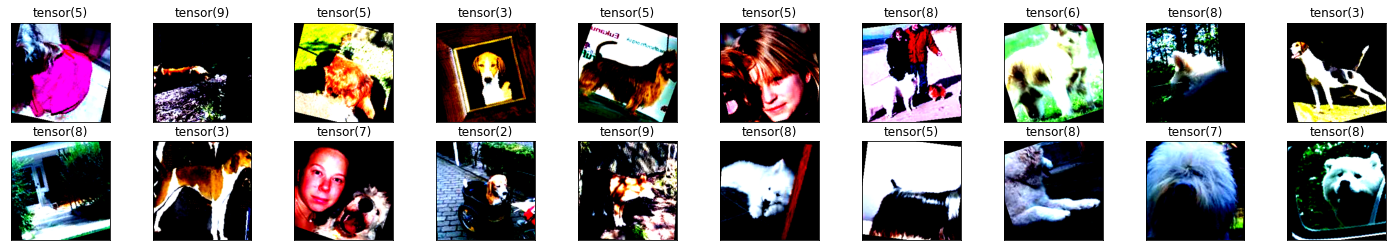

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

## Train Function

In [19]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, new_optim = None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 

    if new_optim:
      optimizer = optim
    else:
      optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)
      
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1
            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()
                
            optimizer.zero_grad()
            output = net(image)
            train_accuracy(output, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_loss = 0

                for image, label in test_loader:
                  if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                  output = net(image)
                  loss = criterion(output, label)
                  test_loss += loss.item()
                  test_accuracy(output, label)
                  if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
              
              # Print out metrics after every (print_every) batches
              net.train()
              total_test_accuracy = test_accuracy.compute()
              total_train_accuracy = train_accuracy.compute()

              for param_group in optimizer.param_groups:
                learning_rate_extract = param_group["lr"]
              print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, steps, learning_rate_extract, 
                                                                                                                                                                 train_loss, total_train_accuracy * 100, 
                                                                                                                                                                 test_loss, total_test_accuracy * 100)) 

              if epoch == (epochs - 1) and batch_idx == (len(train_loader) - 1):
                final_recall = test_recall.compute()
                final_precision = test_prec.compute()
                final_f1 = test_f1.compute()
                print("Final Test Recall Score: {:0.2f}%".format(final_recall * 100))
                print("Final Test Precision Score: {:0.2f}%".format(final_precision * 100))
                print("Final Test F1 Score {:0.2f}%".format(final_f1 * 100))
                print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

              train_loss = 0
              net.train()
    scheduler.step()


In [16]:
#Typical criterion for image classification
criterion = nn.CrossEntropyLoss()

In [20]:
vgg19 = models.vgg19_bn()
for param in vgg19.features.parameters():
    param.requires_grad = False
vgg19.classifier = nn.Sequential(
    nn.Linear(vgg19.classifier[0].in_features, 1000),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(500, 10))
print(vgg19.classifier)
train(vgg19, 1, train_loader, test_loader, 0.003, criterion, print_every = 10)

Sequential(
  (0): Linear(in_features=25088, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=10, bias=True)
)
Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.003
    lr: 0.003
    weight_decay: 0
)
Epoch: 1/1 | Batch Number: 10 | Learning Rate: 0.00300000 | Train Loss: 290.29 | Train Accuracy 8.75% | Test Loss: 192.68 | Test Accuracy 10.21%
Epoch: 1/1 | Batch Number: 20 | Learning Rate: 0.00300000 | Train Loss: 46.06 | Train Accuracy 8.33% | Test Loss: 189.89 | Test Accuracy 10.89%
Epoch: 1/1 | Batch Number: 30 | Learning Rate: 0.00300000 | Train Loss: 24.99 | Train Accuracy 6.88% | Test Loss: 188.57 | Test Accuracy 12.73%
Epoch: 1/1 | Batch Number: 40 | Learning Rate: 0.00300000 | Train Loss: 24.01 |

KeyboardInterrupt: ignored